# TIMESERIES ANOMALY DETECTION
## AUTHOR: ANTE DUJIC
<hr style="border:2px solid gray"> </hr>

<center><img src="https://i0.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection.png?fit=1200%2C800&ssl=1" width="400"/></center>

<hr style="border:2px solid gray"> </hr>

## INTRODUCTION
***

The aim of this notebook is to break down and explain in details the code from [Keras documentation](https://keras.io/examples/timeseries/timeseries_anomaly_detection/) on Timeseries anomaly detection using an Autoencoder.

#### KERAS

Keras is deep learning API developed by Google for implementing neural networks. [3] It makes the implementation of the neural networks easier.

> *Keras is: [2]*
> - *Simple -- but not simplistic. Keras reduces developer cognitive load to free you to focus on the parts of the problem that really matter.*
> - *Flexible -- Keras adopts the principle of progressive disclosure of complexity: simple workflows should be quick and easy, while arbitrarily advanced workflows should be possible via a clear path that builds upon what you've already learned.*
> - *Powerful -- Keras provides industry-strength performance and scalability: it is used by organizations and companies including NASA, YouTube, or Waymo.*

Keras is written in Python and it is running on top of the machine learning platform Tenserflow. Tenserflow is an open-source software library for machine learning and artificial intelligence developed by Google Brain Team. [4] 

The core data structures of Keras are layers and models. The simplest type of model is the Sequential model, a linear stack of layers. [2]

#### AUTOENCODER

An autoencoder is a type of artificial neural network where the input is the same as the output. It works by compressing the input into a lower-dimensional code using encoder and then reconstructing the output from this lower-dimensional representation using decoder. [5]

#### ANOMALY DETECTION

Anomaly detection involves identifying the differences, deviations, and exceptions from the norm in a dataset. It’s sometimes referred to as outlier detection (i.e., looking at a dataset to identify any outlying or unusual datapoints, data groups, or activity).[1]

##### TIMESERIES?


***

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## DATA
***

The data used is [Numenta Anomaly Benchmark(NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab) dataset. NAB provide a controlled and repeatable environment of open-source tools for evaluating real-time anomaly detection algorithms on streaming data. [6] It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. [7] Majority of data is real-world. Data can be found in the [GitHub](https://github.com/numenta/NAB/tree/master/data) repository, in the *data* folder.

```
NAB 
│
│   ...
└───data
│   │
│   └───artificialNoAnomaly
│   │    │   art_daily_small_noise.csv
│   │    │   ...
│   │
│   └───artificialWithAnomaly
│   │    │   art_daily_jumpsup.csv
│   │    │   ...
│   │
│   └─── ...
│
```

In [1]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [8]:
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [7]:
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

##### TIMESERIES DATA WITHOUT ANOMALIES

In [4]:
# 
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [5]:
# 
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [6]:
# 
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# 
df_small_noise.iloc[0]['value']

18.3249185392

In [8]:
# 
df_small_noise.shape

(4032, 1)

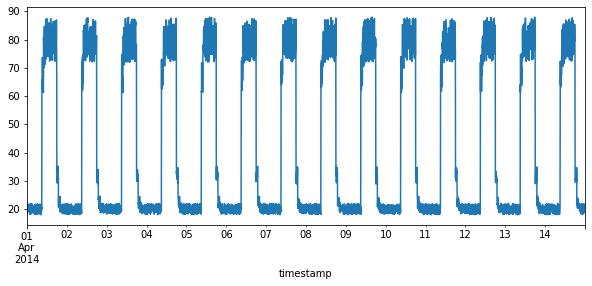

In [9]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

In [10]:
a = df_small_noise
a

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [11]:
sns.boxplot(a)

C:\Users\Kompic\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

LOOK INTO BETTER LOOKING PLOTS

##### TIMESERIES DATA WITH ANOMALIES

In [ ]:
with_anomaly_url

In [ ]:
#
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [ ]:
# 
df_daily_jumpsup.head()

In [ ]:
# 
df_daily_jumpsup.describe()

In [ ]:
# 
df_daily_jumpsup.iloc[0]['value']

In [ ]:
# 
df_daily_jumpsup.shape

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### PREPARE TRAINING DATA

In [ ]:
# 
train_mean = df_small_noise.mean()
train_mean

In [ ]:
# 
train_std = df_small_noise.std()
train_std

The idea is to take the value column and create a new df - Values that are equivalent to the original values, but with the mean of 0 and std of 1. That's done to standardize the effect.

In [ ]:
# 
df_train_vals = (df_small_noise - train_mean) / train_std

In [ ]:
# 
df_train_vals.head()

In [ ]:
# 
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [ ]:
df_small_noise

In [ ]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

In [ ]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [ ]:
print("Number of training samples:", len(df_train_vals))

In [ ]:
# 
window_size = 288

explain window

In [ ]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

In [ ]:
# Number of windows from L.
len(L) - (win_size - 1)

In [ ]:
# Remove brackets.
len(L) - win_size + 1

In [ ]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

In [ ]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

In [ ]:
# Create a 2D numpy array from wins.
np.stack(wins)

In [ ]:
# Generated training sequences for use in the model.
def windows(values, time_steps=window_size):
    # Empty list
    output = []
    # Loop through all the possible windows
    for i in range(len(values) - time_steps + 1):
        # Append the window to the list
        output.append(values[i : (i + time_steps)])
    # Stac the result
    return np.stack(output)

In [ ]:
# 
x_train = windows(df_train_vals)

In [ ]:
# 
x_train[0][0], x_train[-1][-1]

In [ ]:
# 
df_train_vals.iloc[0], df_train_vals.iloc[-1]

In [ ]:
print("Training input shape: ", x_train.shape)

### BUILD A MODEL

In [ ]:
#
layers = [
    # https://keras.io/api/layers/core_layers/input/
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    # https://keras.io/api/layers/convolution_layers/convolution1d/
    keras.layers.Conv1D(
      filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    # https://keras.io/api/layers/regularization_layers/dropout/
    keras.layers.Dropout(rate=0.2),
    #
    keras.layers.Conv1D(
      filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    #
    keras.layers.Conv1DTranspose(
      filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    #
    keras.layers.Dropout(rate=0.2),
    #
    keras.layers.Conv1DTranspose(
      filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    #
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [ ]:
#
model = keras.Sequential(layers)

In [ ]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [ ]:
model.summary()

### TRAIN THE MODEL

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

In [ ]:
history.history["loss"]

In [ ]:
history.history["val_loss"]

explain history object

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

### ANOMALY DETECTION

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

In [ ]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [ ]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
# 
print("Reconstruction error threshold: ", threshold)

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [ ]:
# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [ ]:
# Create sequences from test values.
x_test = windows(df_test_value.values)
print("Test input shape: ", x_test.shape)

In [ ]:
# 
x_test_pred = model.predict(x_test)

In [ ]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

In [ ]:
# 
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss

In [ ]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

In [ ]:
print("Number of anomaly samples: ", np.sum(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [ ]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

In [ ]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");

### REFERENCES

1. https://thedatascientist.com/anomaly-detection-why-you-need-it/
2. https://keras.io/about/
3. https://www.simplilearn.com/tutorials/deep-learning-tutorial/what-is-keras
4. https://en.wikipedia.org/wiki/TensorFlow
5. https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
6. https://www.kaggle.com/datasets/boltzmannbrain/nab
7. https://paperswithcode.com/dataset/nab